# ARID1A phosphoproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
en_object = cptac.Endometrial()
desired_cutoff = .2

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n')
endometrial_freq_mut.loc[endometrial_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 10 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
0,ARID1A,0.452632,0.136842,0.4


## Step 3: Select ARID1A, a frequently mutated gene

In [3]:
gene = 'ARID1A'

## Step 4: Select phosphoproteomics

In [4]:
omics = en_object.get_phosphoproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [152]:
def format_phospho_cis_comparison(cancer_object, omics_name, gene, specific_phospho):
    import numpy as np
    # Step 1 - Create dataframe in order to do comparisons with wrap_ttest
    omics_and_mut = cancer_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = omics_name, omics_genes = gene)
   

    # Step 2 - Create the binary column needed to do the comparison
    omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
        lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
    binary_phospho = tumors[[specific_phospho, 'binary_mutations']].dropna(axis = 0)

    return binary_phospho

In [153]:
specific_phospho_name = 'ARID1A-S1182_phosphoproteomics'

In [155]:
m = format_phospho_cis_comparison(en_object, 'phosphoproteomics', 'ARID1A', specific_phospho_name)


In [156]:
print("Doing t-test comparison for mutation status\n")
pval_df = pd.DataFrame()
for col_label, content in omics_mutations.items():
    formatted_phospho_df = format_phospho_cis_comparison(en_object, 'phosphoproteomics', gene, col_label)
    
    # check correctly formatted
    check_binary = len(formatted_phospho_df['binary_mutations'].unique()) == 2
    check_num_data = len(formatted_phospho_df.index) > 9 # (95 * .1) = 9.5
    if check_num_data & check_binary:
        omics_col_list = [col_label] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(formatted_phospho_df, 'binary_mutations', omics_col_list)
        pval_df = pval_df.append(significant_pval_results, ignore_index = True)
pval_df    

Doing t-test comparison for mutation status

No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.


,Comparison,P_Value
0,ARID1A-S1182_phosphoproteomics,5.517951e-03
1,ARID1A-S1184_phosphoproteomics,4.338936e-07
2,ARID1A-S1600_phosphoproteomics,3.103462e-04
3,ARID1A-S1602_phosphoproteomics,1.163528e-02
4,ARID1A-S1604_phosphoproteomics,1.501846e-06
5,ARID1A-S1751_phosphoproteomics,1.897477e-04
6,ARID1A-S1755_phosphoproteomics,7.963747e-10
7,ARID1A-S363_phosphoproteomics,3.402219e-05
8,ARID1A-S604_phosphoproteomics,4.944088e-03
9,ARID1A-S607_phosphoproteomics,1.301296e-02


In [8]:
# Step 2 - create binary column
omics_and_mutations['binary_mutations'] = omics_and_mutations[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')
tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status", "binary_mutations"]
omics_mutations = tumors.drop(columns_to_drop, axis = 1)

# join binary col
bin_mut = tumors['binary_mutations'] # binary for tumor (no Normal samples)
omics_bin_mut = omics_mutations.join(bin_mut)

In [27]:
print("Doing t-test comparison for mutation status\n")
pval_df = pd.DataFrame()

for col_label, content in omics_mutations.items():
    existing_measurements = content.to_frame().dropna() #drop missing phospho measurements in specific col
    phsph_tumors = existing_measurements.join(bin_mut, how = 'inner') #FIX inner?
    #print(phsph_tumors)
    # check correctly formatted
    check_binary = len(phsph_tumors['binary_mutations'].unique()) == 2
    #check_not_empty = len(phsph_tumors.index) != 0
    check_num_data = len(phsph_tumors.index) > 9 # 95 * .1 = 9.5
    if check_num_data & check_binary:
        #print(col_label,len(phsph_tumors.index))
        omics_col_list = [col_label] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(phsph_tumors, 'binary_mutations', omics_col_list)
        pval_df = pval_df.append(significant_pval_results, ignore_index = True)
pval_df    

Doing t-test comparison for mutation status

No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.


,Comparison,P_Value
0,ARID1A-S1182_phosphoproteomics,5.517951e-03
1,ARID1A-S1184_phosphoproteomics,4.338936e-07
2,ARID1A-S1600_phosphoproteomics,3.103462e-04
3,ARID1A-S1602_phosphoproteomics,1.163528e-02
4,ARID1A-S1604_phosphoproteomics,1.501846e-06
5,ARID1A-S1751_phosphoproteomics,1.897477e-04
6,ARID1A-S1755_phosphoproteomics,7.963747e-10
7,ARID1A-S363_phosphoproteomics,3.402219e-05
8,ARID1A-S604_phosphoproteomics,4.944088e-03
9,ARID1A-S607_phosphoproteomics,1.301296e-02


In [105]:
# create data frame for boxplot with all sig sites
phospho_list = list(pval_df['Comparison'])
all_data = pd.DataFrame()
for phospho_name in phospho_list:
    real = omics_bin_mut[[phospho_name, "binary_mutations"]].dropna(axis = 0) #drop rows with missing measurements
    concise_phospho_name = phospho_name.replace('_phosphoproteomics', '')
    real = real.assign(specific_phospho = concise_phospho_name)
    real = real.rename(columns={ real.columns[0]: "phosphoproteomics" })
    all_data = pd.concat([real, all_data], axis = 0)
all_data.loc[all_data['specific_phospho'] == 'ARID1A-S1182']

,phosphoproteomics,binary_mutations,specific_phospho
Sample_ID,,,
S005,0.36000,Wildtype,ARID1A-S1182
S024,-0.66800,Mutated,ARID1A-S1182
S025,0.57700,Wildtype,ARID1A-S1182
S031,0.25500,Wildtype,ARID1A-S1182
S061,0.05410,Wildtype,ARID1A-S1182
S066,0.22900,Wildtype,ARID1A-S1182
S072,0.14300,Wildtype,ARID1A-S1182
S081,-0.00784,Wildtype,ARID1A-S1182
S088,0.50600,Wildtype,ARID1A-S1182


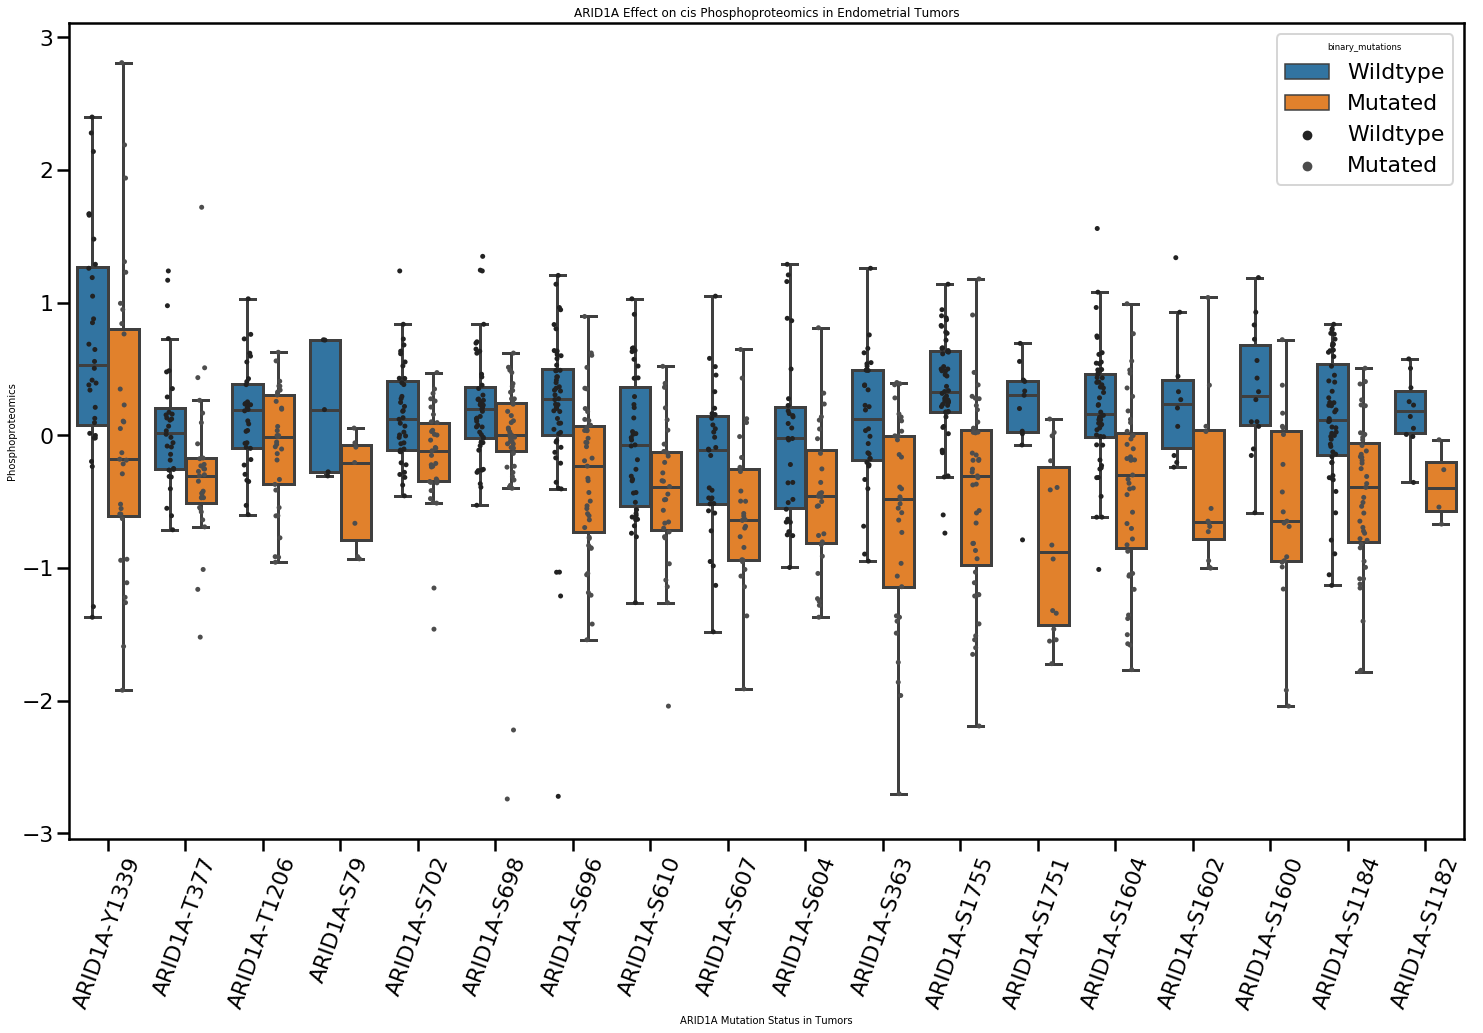

In [78]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set_context(font_scale = 8)
en_cis_boxplot = sns.boxplot(data = all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Phosphoproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation=70)
plt.show()
plt.clf()
plt.close()

There is a decrease in ??proteomics abundance? phosphorylation? in the mutated samples compared to the wildtype.

Mutation type

In [110]:
# check all or just sig from last test?
phospho_list = list(pval_df['Comparison'])
mutation_type_pval = pd.DataFrame()
for name in phospho_list:
    formated_phospho = get_missence_truncation_phospho(en_object, 'phosphoproteomics', 'ARID1A', name)
    check_num_sample = len(n) > 9
    if check_num_sample:
        omics_col_list = [name] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(formated_phospho, 'binary_mutations', omics_col_list)
        mutation_type_pval = mutation_type_pval.append(significant_pval_results, ignore_index = True)
mutation_type_pval

No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.


""


In [ ]:
en_type = f.get_missence_truncation_comparison(en_object, omics, 'proteomics', gene)
#print(mutation_type_comparison.head())

# T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(en_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

# Step 5 - Create boxplt to compare mutation type effect on omics data
en_cis_boxplot = sns.boxplot(data = en_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Mutation Type Effect on cis Proteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= en_type, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Missence","Truncation"])
en_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [ ]:
colon_object = cptac.Colon()
desired_cutoff = .2

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n')
colon_freq_mut.loc[colon_freq_mut['Gene'] == 'ARID1A']

In [ ]:
gene = 'ARID1A'

co_omics = colon_object.get_proteomics()

In [ ]:
co_status = f.format_cis_comparison_data(colon_object, co_omics, 'proteomics', gene)
#co_data_for_comparison.head()

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(co_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

cis_boxplot = sns.boxplot(data = co_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on cis Proteomics in Colon Tumors")
cis_boxplot = sns.stripplot(data = co_status, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", 
                            order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [ ]:
co_type = f.get_missence_truncation_comparison(colon_object, co_omics, 'proteomics', gene)

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(co_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)


co_cis_boxplot = sns.boxplot(data = co_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
co_cis_boxplot.set_title(gene + " Mutation Type Effect on cis Proteomics in Colon Tumors")
co_cis_boxplot = sns.stripplot(data= co_type, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Missence","Truncation"])
co_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Visualize Pancancer effects

In [ ]:
# Create a dataframe with pancancer data for mutation status and type
en_mut_status = en_status.assign(Cancer= 'Endo')
co_mut_status = co_status.assign(Cancer= 'Colon')
en_mut_type = en_type.assign(Cancer= 'Endo')
co_mut_type = co_type.assign(Cancer= 'Colon')

pancancer_data = pd.concat([en_mut_status, co_mut_status, en_mut_type, co_mut_type]) 
pancancer_df = pd.melt(pancancer_data, id_vars=['Cancer','binary_mutations'], value_name= 'Proteomics')  

# Visualize mutation status (mutated vs wildtype) accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data=pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Status Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data=pancancer_df,
                            jitter = True, color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Status", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

# Visualize mutation status (missense vs truncation) accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Missence', 'Truncation'], data = pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Type Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data = pancancer_df, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Missence', 'Truncation'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

# Analysis of Results

Endometrial and colon tumors showed decreased proteomics abundance for the tumors with the mutated gene compared to the wildtype, with endometrial tumors showing the most difference.
All other results were insignificant. Since the ovarian dataset only contains four mutated data points, it is possible that more data collection may show that ovarian cancer follows the same trend.